In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 

In [3]:
#reading in CSV's from a file path
train_df = pd.read_csv('survey.csv')


#Pandas: whats the data row count?
print(train_df.shape)
    
#Pandas: whats the distribution of the data?
print(train_df.describe())
    
#Pandas: What types of data do i have?
print(train_df.info())

(1259, 27)
                Age
count  1.259000e+03
mean   7.942815e+07
std    2.818299e+09
min   -1.726000e+03
25%    2.700000e+01
50%    3.100000e+01
75%    3.600000e+01
max    1.000000e+11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
Timestamp                    1259 non-null object
Age                          1259 non-null int64
Gender                       1259 non-null object
Country                      1259 non-null object
state                        744 non-null object
self_employed                1241 non-null object
family_history               1259 non-null object
treatment                    1259 non-null object
work_interfere               995 non-null object
no_employees                 1259 non-null object
remote_work                  1259 non-null object
tech_company                 1259 non-null object
benefits                     1259 non-null object
care_options                 1259 non-null object
welln

In [4]:
train_df = train_df.drop(['comments'], axis= 1)
train_df = train_df.drop(['state'], axis= 1)
train_df = train_df.drop(['Timestamp'], axis= 1)

In [5]:
print(train_df['Gender'].unique())

['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']


In [6]:
gender = train_df['Gender'].str.lower()
#print(gender)

#Select unique elements
gender = train_df['Gender'].unique()

#Made gender groups
male_str = ["male", "m", "male-ish", "maile", "mal", "male (cis)", "make", "male ", "man","msle", "mail", "malr","cis man", "Cis Male", "cis male"]
trans_str = ["trans-female", "something kinda male?", "queer/she/they", "non-binary","nah", "all", "enby", "fluid", "genderqueer", "androgyne", "agender", "male leaning androgynous", "guy (-ish) ^_^", "trans woman", "neuter", "female (trans)", "queer", "ostensibly male, unsure what that really means"]           
female_str = ["cis female", "f", "female", "woman",  "femake", "female ","cis-female/femme", "female (cis)", "femail"]

for (row, col) in train_df.iterrows():

    if str.lower(col.Gender) in male_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='male', inplace=True)

    if str.lower(col.Gender) in female_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='female', inplace=True)

    if str.lower(col.Gender) in trans_str:
        train_df['Gender'].replace(to_replace=col.Gender, value='trans', inplace=True)

stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Gender'].isin(stk_list)]

print(train_df['Gender'].unique())

['female' 'male' 'trans']


In [7]:
print(sorted(train_df['Age'].unique()))

[-1726, -29, 5, 11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72, 329, 99999999999]


In [8]:
# filling in unreasonable ages with median
s = pd.Series(train_df['Age'])
s[s<18] = train_df['Age'].median()
train_df['Age'] = s
s = pd.Series(train_df['Age'])
s[s>80] = train_df['Age'].median()
train_df['Age'] = s

In [9]:
# fixed ages
print(sorted(train_df['Age'].unique()))

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 60, 61, 62, 65, 72]


In [10]:
train_df['self_employed'].value_counts()

No     1095
Yes     144
Name: self_employed, dtype: int64

In [11]:
# 1.4% are NAs, but no easy replacement
(sum(train_df['self_employed'].isna()))/len(train_df)

0.014319809069212411

In [12]:
train_df['work_interfere'].value_counts() # lots of NAs, but no easy replacement

Sometimes    465
Never        213
Rarely       173
Often        142
Name: work_interfere, dtype: int64

In [55]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(3)

,Total,Percent
work_interfere,264,0.210024
self_employed,18,0.014320
obs_consequence,0,0.000000


In [33]:
train_df['treatment'].value_counts() # about half have mental illness, half don't (or undiagnosed)

Yes    635
No     622
Name: treatment, dtype: int64

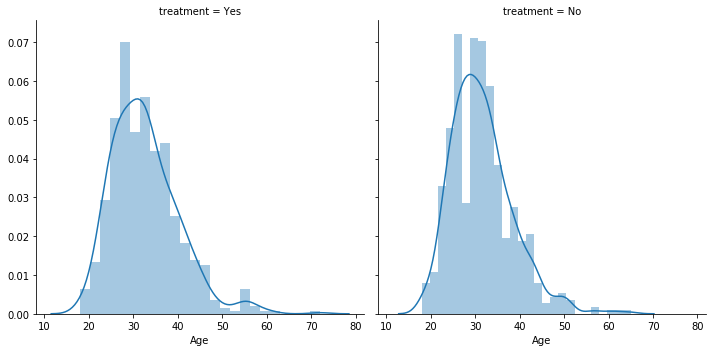

In [34]:
# age distribution by treated
# Separate by treatment or not

g = sns.FacetGrid(train_df, col='treatment', size=5)
g = g.map(sns.distplot, "Age")

In [35]:
train_df['Gender'].value_counts()

male      991
female    247
trans      19
Name: Gender, dtype: int64

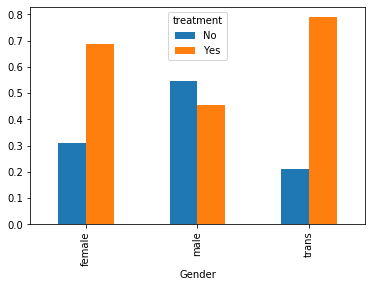

In [54]:
# distribution of mental health condition by gender: trans > female > male
gender_tmt = pd.crosstab(train_df['Gender'], train_df['treatment'], normalize = 'index')
gender_tmt.plot(kind='bar', stacked=False)
plt.show()

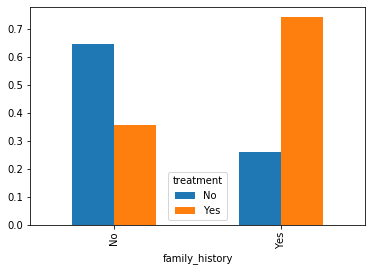

In [60]:
# distribution of mental health condition by family history: those with family history are at higher risk
hist_tmt = pd.crosstab(train_df['family_history'], train_df['treatment'], normalize = 'index')
hist_tmt.plot(kind='bar', stacked=False)
plt.show()

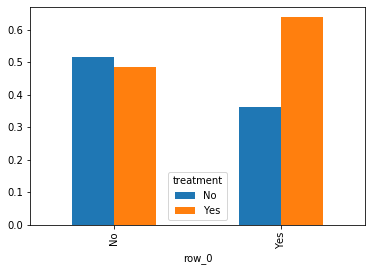

In [62]:
# distribution of mental health condition by work benefits
# more likely to seek treatment, or detrimental effect?

benefit_tmt = pd.crosstab(pd.Categorical(train_df['benefits']).remove_categories("Don't know"), train_df['treatment'], normalize = 'index')
benefit_tmt.plot(kind='bar', stacked=False)
plt.show()

In [63]:
# tangible employer-related factors such as benefits, resources, etc relating to mental health
# used to investigate what EMPLOYERS can do to improve mental health
# DV: whether clinically diagnosed with mental illness 
employer_related = ['benefits', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'treatment']
train_employer = train_df[employer_related]